# **<span style="color: #87CEEB;"> GANs and Latent Space Interpolation</span>**

# <span style="color: #9370DB;">**Deep Learning 2025**</span>




### Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

### Load the MNIST thing

Using device: mps
Training set size: 60000
Testing set size: 10000


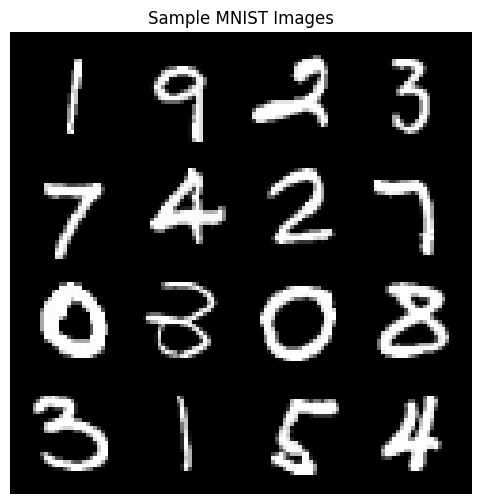

In [ ]:
# Code here
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training set size: {len(train_dataset)}")
print(f"Testing set size: {len(test_dataset)}")

def show_images(dataloader, num_images=16):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    images = images * 0.5 + 0.5

    plt.figure(figsize=(6, 6))
    plt.axis("off")
    plt.title("Sample MNIST Images")
    plt.imshow(np.transpose(vutils.make_grid(images[:num_images], nrow=4, padding=2, normalize=True).cpu(), (1, 2, 0)))
    plt.show()

show_images(train_loader)

## GAN Construction

**Generator (G):** Takes a random noise vector ($z$) as input and generates synthetic image $G(z)$ i.e., an output that aims to resemble real data.
**Discriminator (D):** Acts as a binary classifier that distinguishes between real and fake image. It is trained to correctly identify whether an input is real (from the dataset) or fake (generated by G).

They both compete with each other. The generator tries to fool the discriminator, while the discriminator tries to improve its ability to detect fakes. This adversarial process helps the generator produce increasingly realistic outputs.

In [ ]:
# Code the Generator here
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.1),

            nn.Linear(1024, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Code the Discriminator here
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, 1, 1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [7]:
# initializing the instances of the Generator and Discriminator respectively
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)


Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1152, out_features=128, bias=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Dropout(p=0.4, inplace=False)
    (13): Linear(in_features=128, out_features=1, bias=True)
    (14): Sigmoid()
  )
)

### Losses and optimizers

In [ ]:
# Loss
criterion = nn.BCELoss()

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002)

## Training Loop
Each epoch involves a couple of steps:
1. Prep some data both fake and real
2. Train the discriminator with some real data (real loss)
3. Train the discriminator with some fake data (fake loss)
4. Train the generator (generator loss)

details about losses is below

In [ ]:
epochs = 200

# Training Loop
epoch_g_losses = []
epoch_d_losses = []
nz = 100
best_gen_loss = float('inf')
best_disc_loss = float('inf')

for ep in range(1, epochs + 1):
    total_gen_loss = 0.0
    total_disc_loss = 0.0
    batches = 0

    for imgs, _ in train_loader:
        batches += 1
        imgs = imgs.to(device)
        real_targets = torch.ones(imgs.size(0), 1, device=device)
        fake_targets = torch.zeros(imgs.size(0), 1, device=device)

        # Update Discriminator
        optimizer_d.zero_grad()
        real_pred = discriminator(imgs)
        loss_real = criterion(real_pred, real_targets)
        loss_real.backward()
        noise = torch.randn(imgs.size(0), nz, device=device)
        fake_imgs = generator(noise).view(-1, 1, 28, 28)
        fake_pred = discriminator(fake_imgs.detach())
        loss_fake = criterion(fake_pred, fake_targets)
        loss_fake.backward()
        optimizer_d.step()
        disc_loss = loss_real + loss_fake

        # Update Generator
        optimizer_g.zero_grad()
        noise2 = torch.randn(imgs.size(0), nz, device=device)
        fake_imgs2 = generator(noise2).view(-1, 1, 28, 28)
        fake_pred2 = discriminator(fake_imgs2)
        gen_loss = criterion(fake_pred2, real_targets)
        gen_loss.backward()
        optimizer_g.step()

        total_gen_loss += gen_loss.item()
        total_disc_loss += disc_loss.item()

    avg_gen_loss = total_gen_loss / batches
    avg_disc_loss = total_disc_loss / batches
    epoch_g_losses.append(avg_gen_loss)
    epoch_d_losses.append(avg_disc_loss)

    print(f"Epoch {ep}/{epochs} | Generator Loss: {avg_gen_loss:.4f} | Discriminator Loss: {avg_disc_loss:.4f}")

    if avg_gen_loss < best_gen_loss:
        best_gen_loss = avg_gen_loss
        torch.save(generator.state_dict(), "26100076_gen.pth")

    if avg_disc_loss < best_disc_loss:
        best_disc_loss = avg_disc_loss
        torch.save(discriminator.state_dict(), "26100076_disc.pth")


Epoch 1/200 | Generator Loss: 2.9081 | Discriminator Loss: 0.4392
Epoch 2/200 | Generator Loss: 2.5484 | Discriminator Loss: 0.3947
Epoch 3/200 | Generator Loss: 3.3196 | Discriminator Loss: 0.2764
Epoch 4/200 | Generator Loss: 3.3331 | Discriminator Loss: 0.2708
Epoch 5/200 | Generator Loss: 3.8867 | Discriminator Loss: 0.1830
Epoch 6/200 | Generator Loss: 4.5973 | Discriminator Loss: 0.1511
Epoch 7/200 | Generator Loss: 4.1419 | Discriminator Loss: 0.1550
Epoch 8/200 | Generator Loss: 4.6528 | Discriminator Loss: 0.1519
Epoch 9/200 | Generator Loss: 4.2560 | Discriminator Loss: 0.1468
Epoch 10/200 | Generator Loss: 4.7735 | Discriminator Loss: 0.1306
Epoch 11/200 | Generator Loss: 4.5395 | Discriminator Loss: 0.1394
Epoch 12/200 | Generator Loss: 5.8047 | Discriminator Loss: 0.1128
Epoch 13/200 | Generator Loss: 4.7589 | Discriminator Loss: 0.1543
Epoch 14/200 | Generator Loss: 5.4925 | Discriminator Loss: 0.1030
Epoch 15/200 | Generator Loss: 5.1669 | Discriminator Loss: 0.1115
Epoc

### Display stats

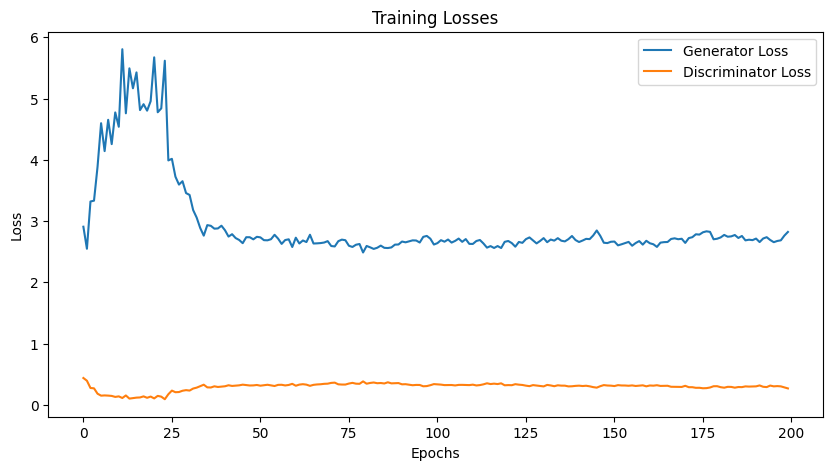

C:\Users\Taha Faisal\AppData\Local\Temp\ipykernel_16320\1481828905.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_generator.load_state_dict(torch.load("26100076_g

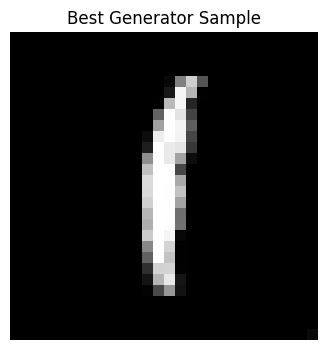

In [ ]:
# code
plt.figure(figsize=(10,5))
plt.plot(epoch_g_losses, label="Generator Loss")
plt.plot(epoch_d_losses, label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.legend()
plt.show()

best_generator = generator.to(device)
best_generator.load_state_dict(torch.load("26100076_gen.pth"))
best_generator.eval()

with torch.no_grad():
    fixed_noise = torch.randn(1, 100).to(device)
    best_fake_images = best_generator(fixed_noise).detach().cpu()
    best_fake_images = best_fake_images.view(1, 28, 28)

plt.figure(figsize=(4,4))
plt.imshow(best_fake_images[0], cmap="gray")
plt.title("Best Generator Sample")
plt.axis("off")
plt.show()


### Latent space interpolation with MNIST
The latent space is the space of all possible inputs that the generator can take, and it is a vector space, and since it is a vector space we can do some vector operations on it, such as interpolation, which is what we will be doing here.
To read up more on this, you can visit the following link: https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/


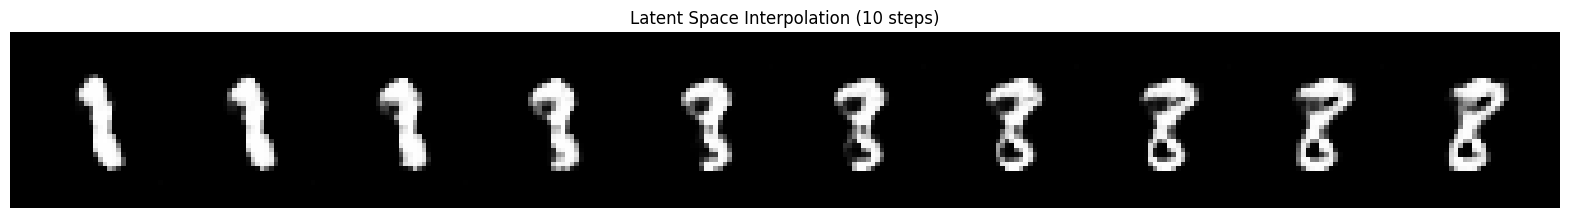

In [ ]:
nz = 100
z1 = torch.randn(1, nz, device=device)
z2 = torch.randn(1, nz, device=device)
num_steps = 10
interpolated_imgs = []
alphas = np.linspace(0, 1, num_steps)

for alpha in alphas:
    z_interp = alpha * z1 + (1 - alpha) * z2
    with torch.no_grad():
        img_interp = generator(z_interp).view(1, 1, 28, 28)
    interpolated_imgs.append(img_interp)

all_images = torch.cat(interpolated_imgs, 0)
grid = vutils.make_grid(all_images, nrow=num_steps, normalize=True, padding=5)

plt.figure(figsize=(num_steps * 2, 3))
plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)), cmap="gray")
plt.title("Latent Space Interpolation (10 steps)")
plt.axis("off")
plt.show()


### Latent space interpolation with pre-trained CelebA
`CelebA` dataset contains ~200,000 images of 178×218 consisting of celebrity faces. Luckily, you don't have to train your GAN over this cuz we're providing you with the pretrained model (and template code to load it). You can download the pre-trained generator from [here](https://pern-my.sharepoint.com/:f:/g/personal/24100238_lums_edu_pk/Eumg8ej04zBJigkuymRYz9MBFRscbETu-NzdzA6tsvYQPQ?e=50uaWN). There's also a `dcgan.py` file (that you're supposed to put in the current directory). 


In [ ]:
from dcgan import DCGAN
generator_path = "generator.pt"
gan = DCGAN(gan_type="gan", use_cuda=True)
gan.load_model(filename=generator_path, use_cuda=torch.cuda.is_available())
gan.eval()
gan = gan.to(device)
print("Number of parameters in the pre-trained generator:", gan.get_num_params())
# gan = gan.cuda()  # Move to GPU if available

Loading generator checkpoint from: generator.pt
Number of parameters in the pre-trained generator: 3592064


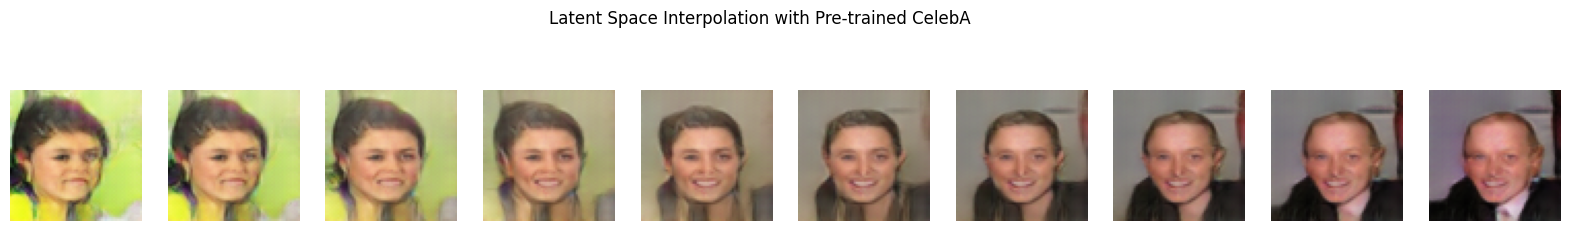

In [ ]:
'''
TODO:
1- Visualize the images generated from z1 and z2
2- Interpolate from z1 to z2 (using the formula given above) and
   plot all interpolation (just like the given example). This task
   is more or less similar to the one you did with MNIST.
3- Make sure interpolation has minimum of 10 steps.
'''

z1 = torch.randn(1, 100, device=device)
z2 = torch.randn(1, 100, device=device)
num_steps = 10
gen_imgs = []
with torch.no_grad():
    for Alp in np.linspace(0, 1, num_steps):
        z_interp =  (Alp * z2) + (1 - Alp) * z1
        out_img = gan.generate_img(z_interp)
        gen_imgs.append(out_img.cpu())

fig, axes = plt.subplots(1, num_steps, figsize=(20, 3))
for j, ax in enumerate(axes):
    image = (gen_imgs[j].squeeze() + 1) / 2.0
    ax.imshow(image.permute(1, 2, 0).numpy())
    ax.axis('off')

plt.suptitle("Latent Space Interpolation with Pre-trained CelebA")
plt.show()


### Vector arithmatic in the latent space
Since issa vector space, you can perform arithmatics (such as subtraciton, addition etc.)
<br>

In [ ]:
def display_images(images, titles, img_size=3):
    num_images = len(images)
    fig, axs = plt.subplots(1, num_images, figsize=(img_size * num_images, img_size))

    if num_images == 1:
        axs = [axs]

    for idx, ax in enumerate(axs):
        img = (images[idx].squeeze() + 1) / 2.0
        ax.imshow(img.permute(1, 2, 0).cpu().numpy())
        ax.set_title(titles[idx])
        ax.axis("off")

    plt.subplots_adjust(wspace=0)
    plt.show()


## A + B

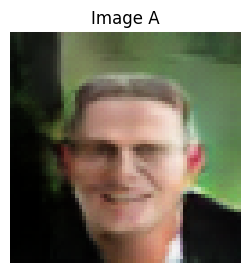

In [77]:
latent_A = torch.randn(1, 100, device=device)
with torch.no_grad():
    image_A = gan.generate_img(latent_A)
display_images([image_A],
               ["Image A"])

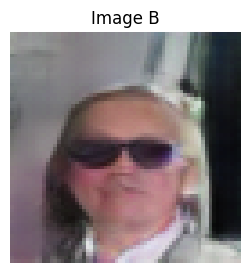

In [94]:
latent_B = torch.randn(1, 100, device=device)
with torch.no_grad():
    image_B = gan.generate_img(latent_B)
display_images([image_B],
               ["Image B"])

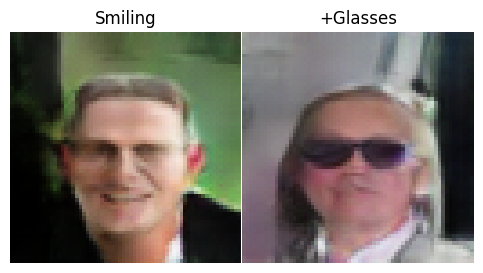

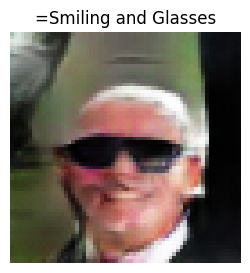

In [96]:
# display random images from the generator, then dispaly there arithmetic.
with torch.no_grad():
    latent_sum_AB = latent_A + latent_B
    image_sum_AB = gan.generate_img(latent_sum_AB)

display_images([image_A, image_B],
               ["Smiling", "+Glasses"])
display_images([image_sum_AB], ["=Smiling and Glasses"])


## C - D

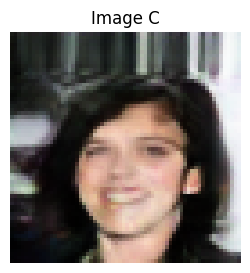

In [288]:
latent_C = torch.randn(1, 100, device=device)
with torch.no_grad():
    image_C = gan.generate_img(latent_C)

display_images([image_C],
               ["Image C"])


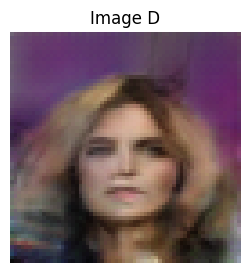

In [307]:
latent_D = torch.randn(1, 100, device=device)
with torch.no_grad():
    image_D = gan.generate_img(latent_D)

display_images([image_D],
               ["Image D"])

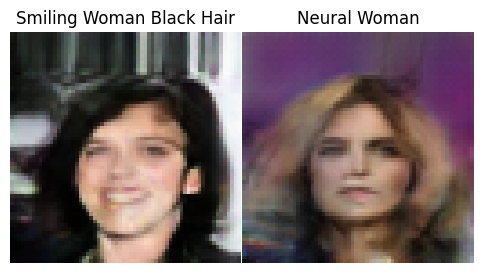

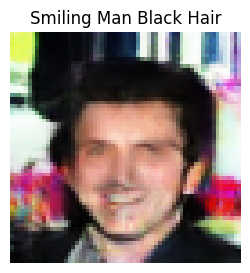

In [412]:
# display random images from the generator, then dispaly there arithmetic.
with torch.no_grad():
    latent_diff_CD = latent_C - latent_D
    image_diff_CD = gan.generate_img(latent_diff_CD)


display_images([image_C, image_D],
               ["Smiling Woman Black Hair", "Neural Woman"])
display_images([image_diff_CD], ["Smiling Man Black Hair"])


## E - F  + G

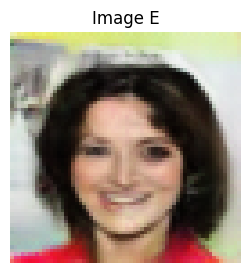

In [363]:
latent_E = torch.randn(1, 100, device=device)
with torch.no_grad():
    image_E = gan.generate_img(latent_E)

display_images([image_E],
               ["Image E"])

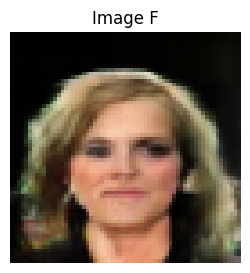

In [406]:
latent_F = torch.randn(1, 100, device=device)
with torch.no_grad():
    image_F = gan.generate_img(latent_F)

display_images([image_F],
               ["Image F"])

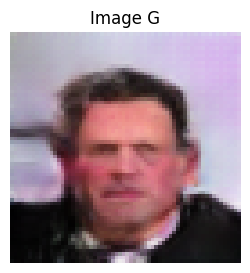

In [402]:
latent_G = torch.randn(1, 100, device=device)
with torch.no_grad():
    image_G = gan.generate_img(latent_G)

display_images([image_G],
               ["Image G"])

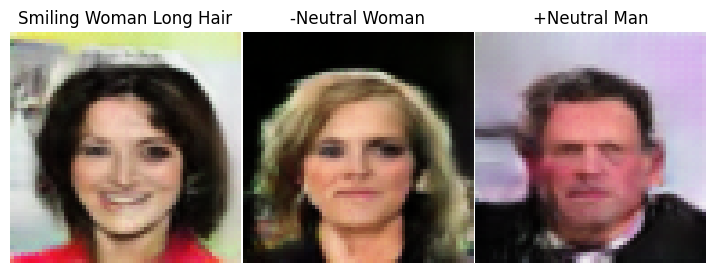

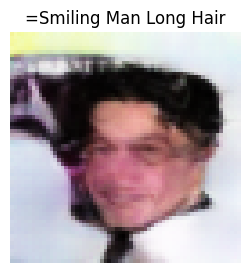

In [411]:
# display random images from the generator, then dispaly there arithmetic.
with torch.no_grad():
    latent_combined = latent_E - latent_F + latent_G
    image_combined = gan.generate_img(latent_combined)


display_images([image_E, image_F, image_G],
               ["Smiling Woman Long Hair", "-Neutral Woman", "+Neutral Man"])
display_images([image_combined], ["=Smiling Man Long Hair"])